<b>Notebook for exploring tourism intensity and other spatial attributes based on Inside Airbnb listing data </b>

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from geopandas import GeoDataFrame
from shapely.geometry import Point

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
pd.options.display.max_columns = None

In [26]:
#loading inside airbnb data
download_url = "http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2019-05-06/data/listings.csv.gz"
cols= ['id','room_type','beds','latitude','longitude','availability_365','host_is_superhost','price','number_of_reviews']
airbnb_df = pd.read_csv(download_url,usecols=cols)
airbnb_df['price'] = airbnb_df['price'].str.replace('$','')
airbnb_df['price'] = pd.to_numeric(airbnb_df['price'],errors='coerce')

#loading Amsterdam 2018 census data
nbh_geojson = gpd.read_file("./neighbourhoods_2018.geojson", driver='GeoJSON')
nbh_gdf = GeoDataFrame(nbh_geojson, crs={'init': 'epsg:4326'}, geometry=nbh_geojson['geometry'])
nbh_gdf['area_km2'] = nbh_gdf.to_crs({'init': 'epsg:28992'})['geometry'].area/10**6

In [27]:
geometry = [Point(xy) for xy in zip(airbnb_df['longitude'], airbnb_df['latitude'])]
airbnb_df = airbnb_df.drop(['latitude', 'longitude'], axis=1)
airbnb_gdf = GeoDataFrame(airbnb_df, crs={'init': 'epsg:4326'}, geometry=geometry)

room = airbnb_gdf.loc[airbnb_gdf['room_type'].isin(['Private room','Shared room'])]
entire_home = airbnb_gdf.loc[airbnb_gdf['room_type']=='Entire home/apt']
superhost = airbnb_gdf.loc[airbnb_gdf['host_is_superhost']=='t']

In [28]:
#perform spatial join
join_room = gpd.sjoin(nbh_gdf,room,how='inner',op='contains').groupby('Buurt').size().reset_index(name='Airbnb_RoomRentalCount')
join_entire = gpd.sjoin(nbh_gdf,entire_home,how='inner',op='contains').groupby('Buurt').size().reset_index(name='Airbnb_EntireLodgeCount')
join_superhost = gpd.sjoin(nbh_gdf,superhost,how='inner',op='contains').groupby('Buurt').size().reset_index(name='Airbnb_SuperhostCount')
join_beds = gpd.sjoin(nbh_gdf,airbnb_gdf,how='inner',op='contains').groupby(['Buurt'])['beds'].sum().reset_index(name='Airbnb_BedsCount')
join_price = gpd.sjoin(nbh_gdf,airbnb_gdf,how='inner',op='contains').groupby(['Buurt'])['price'].mean().reset_index(name='Airbnb_AvgPrice')

In [29]:
#merge count data with neighbourhood data
nbh_gdf = nbh_gdf.merge(join_room,on='Buurt')
nbh_gdf = nbh_gdf.merge(join_entire,on='Buurt')
nbh_gdf = nbh_gdf.merge(join_superhost,on='Buurt')
nbh_gdf = nbh_gdf.merge(join_beds,on='Buurt')
nbh_gdf = nbh_gdf.merge(join_price,on='Buurt')
nbh_gdf['Airbnb_ListingCount']= nbh_gdf['Airbnb_RoomRentalCount'] + nbh_gdf['Airbnb_EntireLodgeCount']

In [30]:
#calculate tourist intensity (bed per 1000 inhabitants)
#calculate population density (inhabitant per km2)
nbh_gdf['Airbnb_TouristIntensity'] = (nbh_gdf['Airbnb_BedsCount']/nbh_gdf['2018_tot'])*100
nbh_gdf['PopDensity_km2'] = nbh_gdf['2018_tot']/nbh_gdf['area_km2']
nbh_gdf['Airbnb_TouristIntensity'] = nbh_gdf['Airbnb_TouristIntensity'].replace([np.inf, -np.inf], 0)

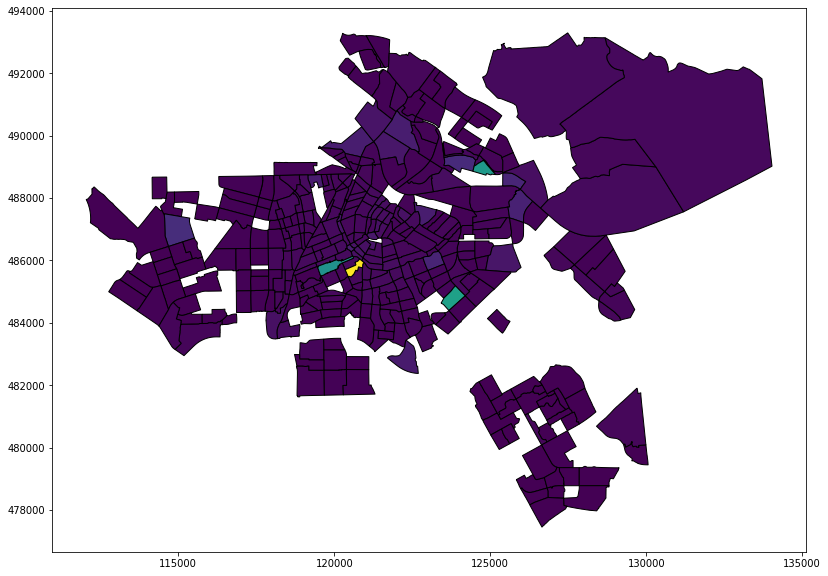

In [31]:
#show spatial distribution
#f,ax = plt.subplots()
#nbh_gdf.to_crs({'init': 'epsg:28992'}).plot(ax=ax, edgecolor='black',column='Airbnb_TouristIntensity')

In [42]:
nbh_gdf.to_file("InsideAirnbnb_analysis_20190506_polygon.geojson", driver="GeoJSON")

In [43]:
airbnb_gdf.to_file("InsideAirbnb_listing_20190506_point.geojson",driver="GeoJSON")